# Follow [Pyro documentation examples](pyro.ai/examples/bayesian_regression.html)

Given data $$ \mathcal{D} = \left\{ \left(X_i, y_i\right)\right\} $$ for $i=1,\ldots,N$. We want to fit a linear model $$ y = wX + b + \epsilon $$ where $\epsilon$ is observation noise, $w$ is a weight matrix, and $b$ is a bias vector.

We can implement standard linear regression in PyTorch; then we can use Pyro to implement Bayesian regression.

In [4]:
import os
from functools import partial
import torch
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pyro 
import pyro.distributions as dist 

%matplotlib inline
plt.style.use("default")

In [5]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

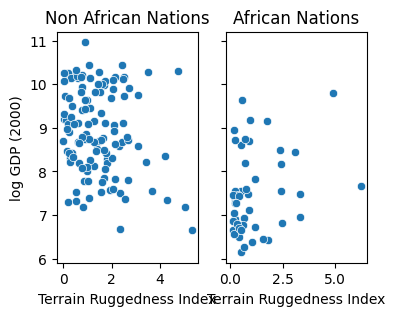

In [6]:
fix, ax = plt.subplots(nrows=1,ncols=2,figsize=(4,3), sharey=True)
african_nations = df[df["cont_africa"]==1]
non_african_nations = df[df["cont_africa"]==0]

sns.scatterplot(non_african_nations["rugged"],
    non_african_nations["rgdppc_2000"],
    ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
    ylabel="log GDP (2000)",
    title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
    african_nations["rgdppc_2000"],
    ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
    ylabel="log GDP (2000)",
    title="African Nations");
plt.show()

Want to predict log GDP per capita based on: terrain ruggedness index and category (African or non-African).

Learnable parameters are `nn.Parameter` objects. 

In [7]:
from torch import nn 
from pyro.nn import PyroModule 

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [9]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"] # interaction term
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3348.1377
[iteration 0100] loss: 1817.0480
[iteration 0150] loss: 1257.9479
[iteration 0200] loss: 935.6300
[iteration 0250] loss: 705.5252
[iteration 0300] loss: 531.4427
[iteration 0350] loss: 402.4644
[iteration 0400] loss: 310.8263
[iteration 0450] loss: 248.4870
[iteration 0500] loss: 207.8198
[iteration 0550] loss: 182.3438
[iteration 0600] loss: 167.0040
[iteration 0650] loss: 158.1205
[iteration 0700] loss: 153.1707
[iteration 0750] loss: 150.5168
[iteration 0800] loss: 149.1475
[iteration 0850] loss: 148.4676
[iteration 0900] loss: 148.1429
[iteration 0950] loss: 147.9937
[iteration 1000] loss: 147.9278
[iteration 1050] loss: 147.8999
[iteration 1100] loss: 147.8886
[iteration 1150] loss: 147.8841
[iteration 1200] loss: 147.8824
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8816
[iteration 1350] loss: 147.8816
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94789

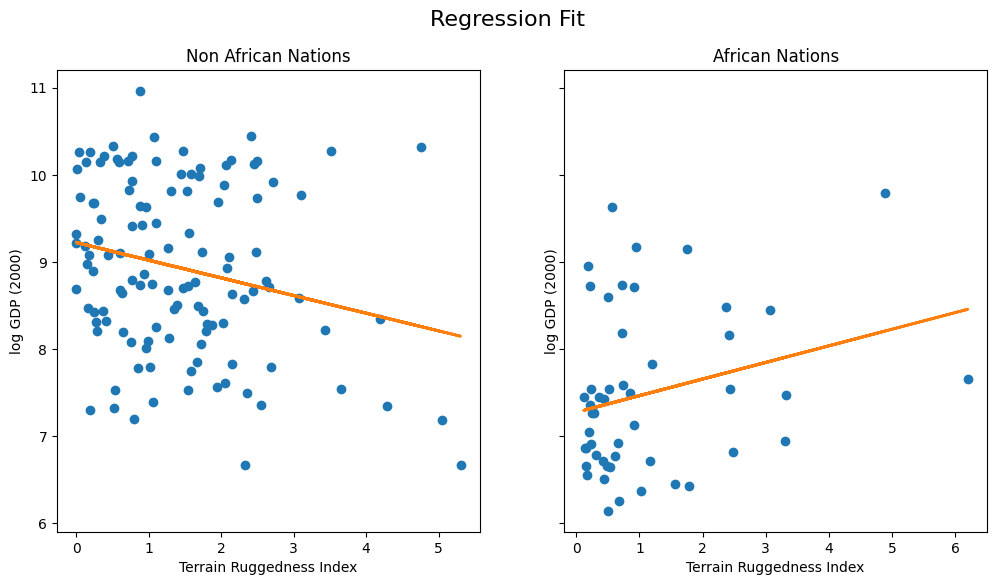

In [10]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [ ]:
from pyro.nn import PyroSample

class BayesianRegression(PyroModule):
    